In [ ]:
### Keras and Tensorflow 2.3

In [180]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd
# Tickers list
# We can add and delete any ticker from the list to get desired ticker live data
ticker_list=['AAPL']
today = date.today()
# We can get data by our choice by giving days bracket
start_date= '2015-01-01'
files=[]
def getData(ticker):
    print (ticker)
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    dataname= ticker+'_'+str(today)
    files.append(dataname)
    SaveData(data, dataname)
# Create a data folder in your current dir.
def SaveData(df, filename):
    df.to_csv('./data/'+filename+'.csv')
    #This loop will iterate over ticker list, will pass one ticker to get data,
    #and save that data as file.
for tik in ticker_list:
    getData(tik)
for i in range(0,len(ticker_list)):
    df= pd.read_csv('./data/'+ str(files[i])+'.csv')
    print(df.tail(10))

AAPL
[*********************100%***********************]  1 of 1 completed
            Date        Open        High         Low       Close   Adj Close  \
1481  2020-11-17  119.550003  120.669998  118.959999  119.389999  119.389999   
1482  2020-11-18  118.610001  119.820000  118.000000  118.029999  118.029999   
1483  2020-11-19  117.589996  119.059998  116.809998  118.639999  118.639999   
1484  2020-11-20  118.639999  118.769997  117.290001  117.339996  117.339996   
1485  2020-11-23  117.180000  117.620003  113.750000  113.849998  113.849998   
1486  2020-11-24  113.910004  115.849998  112.589996  115.169998  115.169998   
1487  2020-11-25  115.550003  116.750000  115.169998  116.029999  116.029999   
1488  2020-11-27  116.570000  117.489998  116.220001  116.589996  116.589996   
1489  2020-11-30  116.970001  120.970001  116.809998  119.050003  119.050003   
1490  2020-12-01  121.010002  123.470001  120.010002  122.720001  122.720001   

         Volume  
1481   74271000  
1482   76

In [181]:
df1=df.reset_index()['Close']
print(df1.head(10))

0    27.594999
1    27.332500
2    26.562500
3    26.565001
4    26.937500
5    27.972500
6    28.002501
7    27.312500
8    27.555000
9    27.450001
Name: Close, dtype: float64


In [182]:
df1

0        27.594999
1        27.332500
2        26.562500
3        26.565001
4        26.937500
           ...    
1486    115.169998
1487    116.029999
1488    116.589996
1489    119.050003
1490    122.720001
Name: Close, Length: 1491, dtype: float64

In [183]:
df1.shape

(1491,)

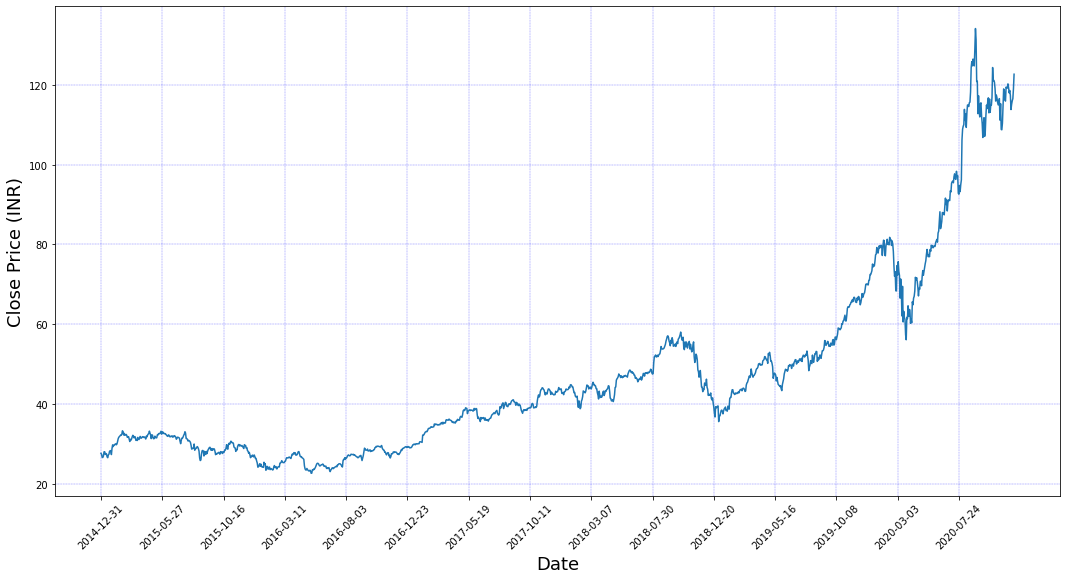

In [184]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,9))
plt.plot(range(df1.shape[0]),(df1))
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [185]:
# LSTMs are very sensetive to scale of data so we'll apply MinMax Scaler

In [186]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.04489449]
 [0.04254224]
 [0.03564229]
 ...
 [0.84237647]
 [0.86442053]
 [0.8973073 ]]


In [187]:
df1

array([[0.04489449],
       [0.04254224],
       [0.03564229],
       ...,
       [0.84237647],
       [0.86442053],
       [0.8973073 ]])

In [188]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(969, 522)

In [189]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 150
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(819, 150)
(819,)
(372, 150)
(372,)


(None, None)

In [190]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [191]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 150, 50)           10400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 150, 50)           20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [192]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 123ms/step - loss: 0.0042 - val_loss: 0.0370
Epoch 2/100
13/13 [==============================] - 1s 47ms/step - loss: 7.5099e-04 - val_loss: 0.0027
Epoch 3/100
13/13 [==============================] - 1s 43ms/step - loss: 3.1033e-04 - val_loss: 0.0035
Epoch 4/100
13/13 [==============================] - 1s 45ms/step - loss: 2.2074e-04 - val_loss: 0.0024
Epoch 5/100
13/13 [==============================] - 1s 45ms/step - loss: 2.0306e-04 - val_loss: 0.0027
Epoch 6/100
13/13 [==============================] - 1s 46ms/step - loss: 1.9732e-04 - val_loss: 0.0022
Epoch 7/100
13/13 [==============================] - 1s 43ms/step - loss: 1.8466e-04 - val_loss: 0.0023
Epoch 8/100
13/13 [==============================] - 1s 43ms/step - loss: 1.7675e-04 - val_loss: 0.0030
Epoch 9/100
13/13 [==============================] - 1s 44ms/step - loss: 1.7721e-04 - val_loss: 0.0030
Epoch 10/100
13/13 [==============================] - 1s 43ms/step 

13/13 [==============================] - 1s 47ms/step - loss: 7.6740e-05 - val_loss: 0.0023
Epoch 80/100
13/13 [==============================] - 1s 45ms/step - loss: 7.0366e-05 - val_loss: 0.0019
Epoch 81/100
13/13 [==============================] - 1s 42ms/step - loss: 6.8057e-05 - val_loss: 0.0019
Epoch 82/100
13/13 [==============================] - 1s 40ms/step - loss: 7.1050e-05 - val_loss: 0.0026
Epoch 83/100
13/13 [==============================] - 1s 41ms/step - loss: 7.0053e-05 - val_loss: 0.0018
Epoch 84/100
13/13 [==============================] - 1s 43ms/step - loss: 6.8487e-05 - val_loss: 0.0017
Epoch 85/100
13/13 [==============================] - 1s 43ms/step - loss: 6.7177e-05 - val_loss: 0.0014
Epoch 86/100
13/13 [==============================] - 1s 42ms/step - loss: 6.8329e-05 - val_loss: 0.0021
Epoch 87/100
13/13 [==============================] - 1s 43ms/step - loss: 6.6642e-05 - val_loss: 0.0023
Epoch 88/100
13/13 [==============================] - 1s 47ms/step -

In [193]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [194]:
##Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [195]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

37.11138678841632

In [196]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

80.68105607860237

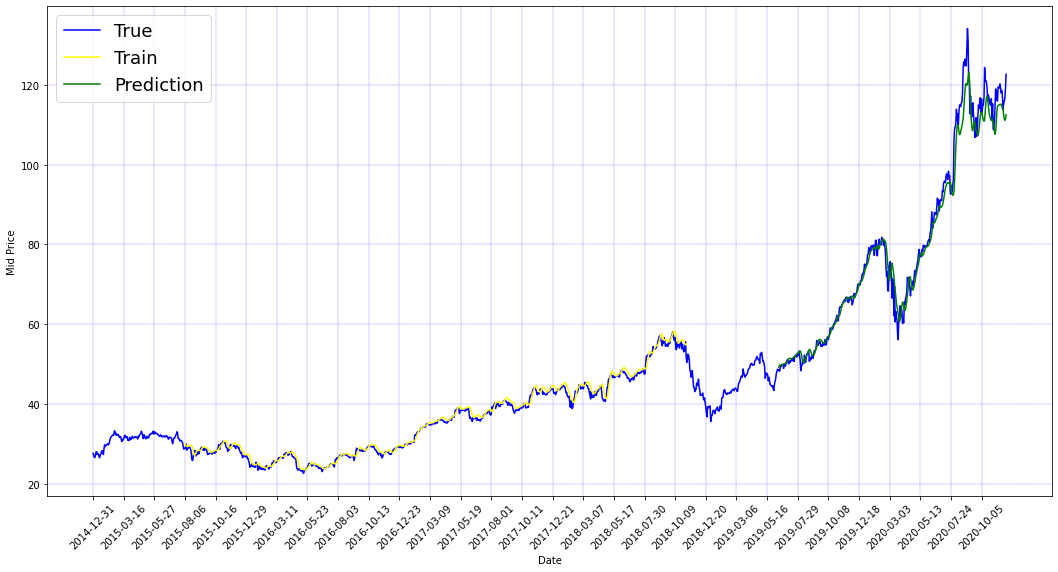

In [198]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(df1), :] = test_predict
# plot baseline and predictions
plt.figure(figsize = (18,9))
plt.plot(scaler.inverse_transform(df1),color='b',label='True')
plt.plot(trainPredictPlot,color='yellow',label='Train')
plt.plot(testPredictPlot,color='green', label='Prediction')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [199]:
len(test_data)

522

In [200]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 150)

In [201]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.4557999980720559,
 0.44520368833509655,
 0.45436627754781095,
 0.4642233368900032,
 0.4711009019702566,
 0.4780680275810885,
 0.49238321870838825,
 0.5033156197188771,
 0.49525072812369536,
 0.48682738930574815,
 0.49106148303077496,
 0.48696179846843307,
 0.5032035665054282,
 0.4991263746259567,
 0.5127694515730146,
 0.5074376602304551,
 0.5120077768621942,
 0.5071688419050853,
 0.5102603210136558,
 0.5105739879711322,
 0.5098795178416542,
 0.5186388795663139,
 0.5219768210510183,
 0.5259644523999112,
 0.5196917969185573,
 0.5402572192111579,
 0.5446480780481056,
 0.5682378432347515,
 0.5880640151325849,
 0.5501142785533502,
 0.5566109720947847,
 0.5659975993675797,
 0.586361407916153,
 0.5852637102986202,
 0.5855773772560966,
 0.5810744652056998,
 0.6015726829169579,
 0.6187329591435116,
 0.6042385785882376,
 0.6149469415386459,
 0.5898338269303596,
 0.6080918007744458,
 0.6148573126412504,
 0.6133115389035564,
 0.6133115389035564,
 0.6351315606592449,
 0.6325328695693078,
 0.6519

In [202]:
# demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i+1,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8247446]
151
2 day output [[0.82868457]]
3 day output [[0.8220558]]
4 day output [[0.8102983]]
5 day output [[0.79682034]]
6 day output [[0.7833202]]
7 day output [[0.77059895]]
8 day output [[0.75906247]]
9 day output [[0.74892944]]
10 day output [[0.7402959]]
11 day output [[0.7331546]]
12 day output [[0.72740924]]
13 day output [[0.7228943]]
14 day output [[0.7193968]]
15 day output [[0.7166803]]
16 day output [[0.7145054]]
17 day output [[0.7126473]]
18 day output [[0.7109097]]
19 day output [[0.70913273]]
20 day output [[0.70719796]]
21 day output [[0.70502985]]
22 day output [[0.7025919]]
23 day output [[0.6998833]]
24 day output [[0.69693047]]
25 day output [[0.6937808]]
26 day output [[0.69049424]]
27 day output [[0.68713623]]
28 day output [[0.68377095]]
29 day output [[0.6804572]]
30 day output [[0.6772441]]


In [203]:
day_new=np.arange(1,1+time_step)
day_pred=np.arange(1+time_step,31+time_step)

In [204]:
len(df1)

1491

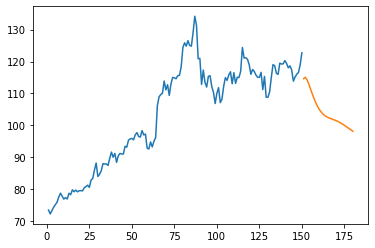

In [205]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-time_step:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

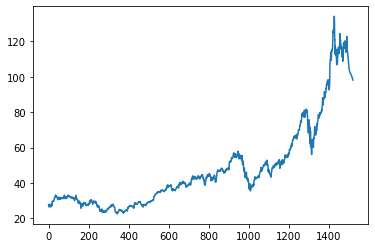

In [206]:
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)